<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/CU/Lab4_Curie_heat_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab4 Curie point experiment - heat capacity extraction

v.0.1.2

Evgeny Kolonsky 2025

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0 as mu0
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.integrate import cumulative_trapezoid as cumtrapz


Heat capacity $C$ when all incoming heat $Q$ is accumulated in the body leading to change of its temperature $T$ is defined by expression $$\dot Q = C \dot T_{heating}.$$

Assuming that there is no cooling
$$
\dot T_{heating} = \frac{\dot Q}{C} = \frac{P}{C}$$
where $ P = I V$ is electric power supplied to the oven.

Cooling proccess is defined by parametric expression
$$
\dot T_{cooling} = -k (T - T_{env})
$$
Parameter $k$ can be extraced from observations when the system is  cooling.

If the process we observe is superposition of simultaneous heating and cooling, then the total temperature change is explained by simultaneous heating and cooling
$$
\dot T = \dot T_{heating} + \dot T_{cooling} = \frac{P}{C} - k (T - T_{env})
$$
$\dot T$ here is the temperature change rate observed in the experiment.

Therefore heat capacity $C$ can be found and heating part of the observations as
$$
C = \frac{P}{\dot T  +k (T - T_{env})}
$$

On the other hand, heat capacity $C$ of the system `oven` $+$ `sample` is
$$
C = C_0 + m  c_p
$$
where $C_0$ is heat capacity of the `oven`, and $m$ and $c_p$ is respectively mass and heat capacity per unit mass of the `sample`.

We expect $c_p$ to double by value in the vicinity  of the Curie point $T_c$ of the sample and then return to it's nominal value ~ $500\,J/kg/K$.   

# Load data and fit `cooling` parameter

/tmp/ipython-input-3345449754.py:25: RuntimeWarning: overflow encountered in exp
  return TENV + (T0 - TENV) * np.exp(-k * (time - t0))
/tmp/ipython-input-3345449754.py:25: RuntimeWarning: overflow encountered in multiply
  return TENV + (T0 - TENV) * np.exp(-k * (time - t0))


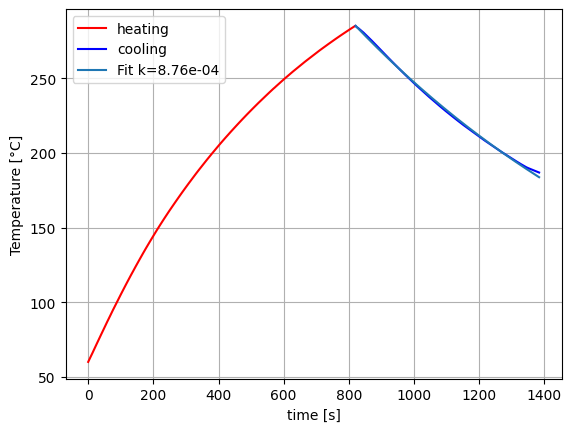

In [51]:
TENV = 25 # celcius
url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/1_2.csv'
temp, V1, V2, phi, V, I = np.loadtxt(url, delimiter=',', skiprows=60, usecols=[1,2,3,4,5,6], unpack=True)
time = np.arange(V1.size)

P = V * I
response = V2 / V1

# timeline
# timeline
# timeline
ix = np.argmax(temp)
t0 = time[ix]
temp_max = np.max(temp)
heating = time < t0
cooling = time > t0



plt.grid()
plt.ylabel('Temperature [°C]')
plt.xlabel('time [s]')

def cooling_law(time, k, T0):
  return TENV + (T0 - TENV) * np.exp(-k * (time - t0))


initial = [0.5, 170]
parameters, _ = curve_fit(cooling_law, time[cooling], temp[cooling], p0=initial)
temp_expected =  cooling_law(time[cooling], *parameters)
k = parameters[0]
plt.plot(time[heating], temp[heating],  label='heating', color='red')
plt.plot(time[cooling], temp[cooling],  label='cooling',  color='blue')
plt.plot(time[cooling], temp_expected, label=f'Fit k={k:.2e}')
plt.legend()

# Extract Curie point from response

In [52]:
def survival_function(x, height, loc, sigma, offset):
    return height * norm.sf(x, loc, sigma) + offset

def smooth(signal, window_size=20):
  # Create the kernel for a simple moving average
  # Each element in the window gets a weight of 1/window_size
  kernel = np.ones(window_size) / window_size
  # Perform the convolution
  smoothed_signal = np.convolve(signal, kernel, mode='same')
  return smoothed_signal

Tc = 242 +- 9 C


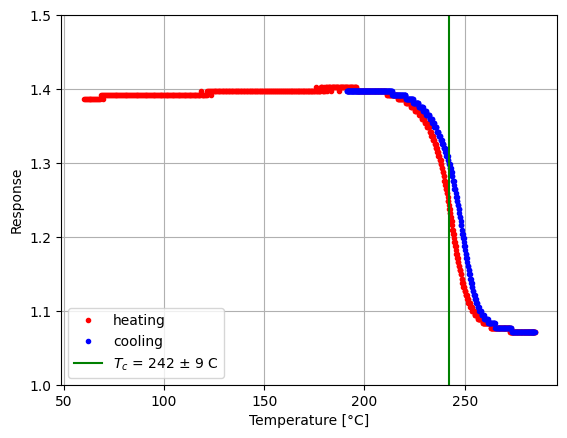

In [53]:
plt.plot(temp[heating], response[heating], '.', color='red', label='heating')
plt.plot(temp[cooling], response[cooling], '.', color='blue', label='cooling')
plt.xlabel('Temperature [°C]')
plt.ylabel('Response')
plt.ylim(1, 1.5)
plt.grid()

temp_c = temp[heating]
response_c = response[heating]

# Fit the heating curve

height = np.max(response) - np.min(response)
offset = np.min(response)
sigma = 10
loc = np.max(temp) - sigma
initial = [height, loc, sigma, offset]

# Fit the cooling curve
popt,  _ = curve_fit(survival_function, temp_c, response_c, p0=initial)


Tc, Tc_sigma = popt[1], popt[2]
print(f'Tc = {Tc:.0f} +- {Tc_sigma:.0f} C')
plt.axvline(Tc, color='green', label=rf'$T_c$ = {Tc:.0f} $\pm$ {Tc_sigma:.0f} C')
plt.legend()
transition = (temp > Tc - 2*Tc_sigma) & (temp < Tc + 2* Tc_sigma)
#plt.plot(temp[transition], response[transition], '.', color='gray', label='transition')

# Plot temperature change on the timline of heating

Text(0, 0.5, '$\\dot T$ [K/s]')

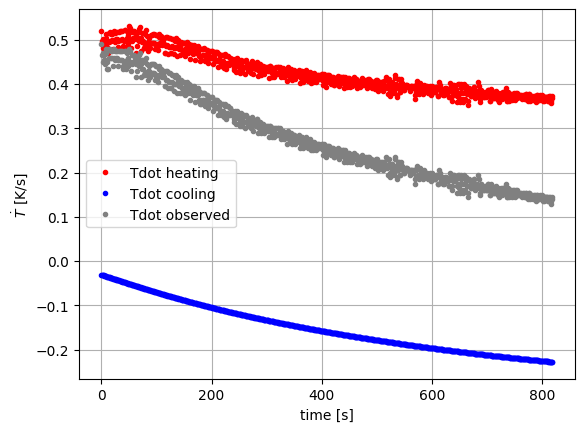

In [54]:
tdot = np.gradient(temp, time)
tdot_cooling = -k * (temp - TENV)
tdot_heating = tdot - tdot_cooling
plt.plot(time[heating] , tdot_heating[heating], '.', color='red', label='Tdot heating')
plt.plot(time[heating] , tdot_cooling[heating], '.', color='blue', label='Tdot cooling')
plt.plot(time[heating] , tdot[heating], '.', color='gray', label='Tdot observed')
plt.legend()
plt.grid()
plt.xlabel('time [s]')
plt.ylabel(r'$\dot T$ [K/s]')
#plt.plot(P[heating] /tdot_heating[heating], '.')
#plt.xlim(500, 1000)
#plt.ylim(0, 100)

# Plot temperature change due to heating on temperature axis

Text(0, 0.5, '$\\dot T$ [K/s]')

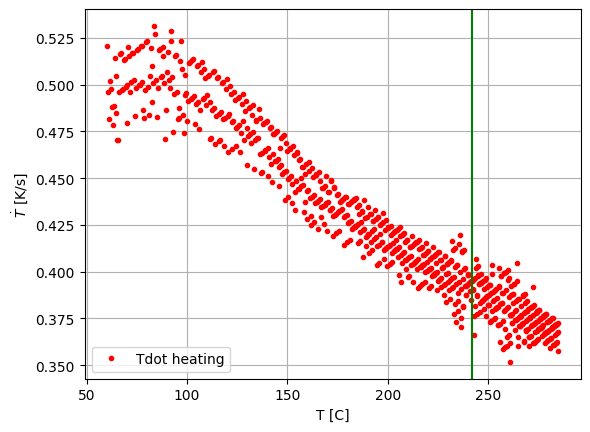

In [55]:
plt.plot(temp[heating] , tdot_heating[heating], '.', color='red', label='Tdot heating')
plt.legend()
plt.grid()
plt.axvline(Tc, color='green')
plt.xlabel('T [C]')
plt.ylabel(r'$\dot T$ [K/s]')

# Plot heat capacity and repsonse as a function of temperature

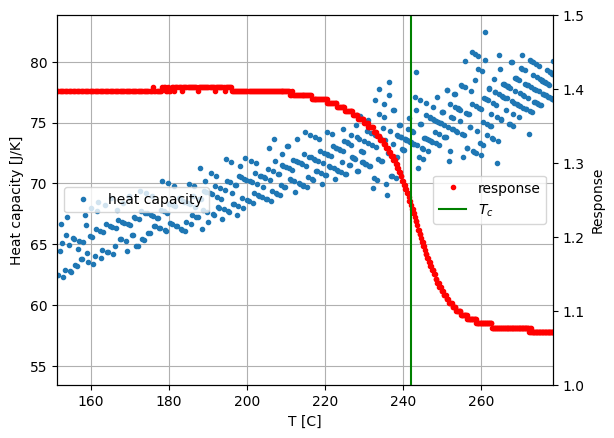

In [56]:
fig, ax = plt.subplots()
C = P[heating] / tdot_heating[heating]
ax.plot(temp[heating], C, '.', label='heat capacity')
ax.grid()
ax.set_xlabel('T [C]')
ax.set_ylabel('Heat capacity [J/K]')
ax.set_xlim(Tc - 10*Tc_sigma, Tc + 4*Tc_sigma)
#ax.set_ylim(50,62)

ax1 = ax.twinx()
ax1.plot(temp[heating], response[heating], 'r.', label='response')
ax1.set_ylabel('Response')
ax1.set_ylim(1.0, 1.5)
ax1.axvline(Tc, color='green', label=r'$T_c$')
ax1.legend()
ax1.legend(loc='center right')
ax.legend()
ax.legend(loc='center left')

# Discussion


If expected heat capacity per unit mass of the system `oven` + `sample` is about 500 - 800 J/kg/K, then the system heated is having mass about 100 g. Known part of this mass is core sample, it about 30 g for invar somehow less for ferrite. According to the model we should observe a doubled value of the sample heat capacity and therefore jump in total capacity of ~20% at the phase transition part of the load.

We observe steady linear change of the heat capacity $C$ around values 50 - 80 J/K, with no obvious change of behavoiur near phase transition part of the temperature load cycle.
